In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

In [4]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B)) # magnetic length
m_sc=3*hwc  # mass term to get quadratic dispersion inside sc
mu_sc=8*hwc # chemical potential of sc
D1=0.5*hwc # inter valley pairing (see my notes)
D2=0.6*hwc # intra valley pairing (see my notes)
nu=0.3 
mu_n=nu*hwc # chemical potential in QH
m_n=0.1*hwc # small mass to lift N=0 LL degeneracy of graphene 

# spin orbit coupling (see my notes)
lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc

# Zeeman splitting
gs=0.0*hwc # inside SC
gn=0.3*hwc # inside QH

Nk=50 # number of k points 
kmax=4/lB # max abs of k
ky_sw=np.linspace(-kmax,kmax,Nk)

Ls=6*lB 
Lx=8*lB
Nx=200 # number of plane waves, don't make this too big, the H matrix to be diagonalized is 16Nx by 16Nx 
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])
s00=np.kron(sigma0,sigma0)
s30=np.kron(sigma3,sigma0)
s01=np.kron(sigma0,sigma1)
s02=np.kron(sigma0,sigma2)


Hx= hbar*vF*np.kron(s30, np.kron(np.diag(kx) , sigma1))
HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma2)
HeBT= 2j*vF*elec*B* np.kron(np.imag(y1(k2-k1)), sigma2)

Hxm= np.kron( m_sc*y0s(k1-k2)+2*m_n*np.real(y0(k1-k2)) , sigma3)
HxmT= np.kron( m_sc*y0s(k2-k1)+2*m_n*np.real(y0(k2-k1)) , sigma3)
Hlx= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k1-k2) , lRx*sigma1)) #1
HlxT= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k2-k1) , lRx*sigma1)) #1
Hly= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k1-k2) , lRy*sigma2)) #2
HlyT= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k2-k1) , lRy*sigma2)) #2
Hlz= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k1-k2) , lso*sigma3)) # 333
HlzT= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k2-k1) , lso*sigma3))
Hl=Hlx+Hly+Hlz
HlT=HlxT+HlyT+HlzT

Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

Hd= np.kron(y0s(k1-k2),sigma0)
# basis ud,ud
dmat2=np.kron(np.array([[0.,1j],[0.,0.]]),D1*sigma1+D2*sigma0)
ddmat2=np.kron(dmat2,sigma2)
Hd_mat=np.kron(ddmat2,Hd)
Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

s03=np.kron(sigma0,sigma3)
Hz_up= -(gs*y0s(k1-k2)+2*gn*np.real(y0(k1-k2)))
Hz= np.kron(s03, np.kron(Hz_up,sigma0) )
Hz_upT= -(gs*y0s(k2-k1)+2*gn*np.real(y0(k2-k1)))
HzT= np.kron(s03, np.kron(Hz_upT,sigma0) )


Vn=np.zeros((16*Nx,16*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((16*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)

    H1 = Hx + np.kron(s00, Hy+ HeB + Hxm + Hef)+ Hz + Hl
    H1T = -Hx  + np.kron(s00,Hy+ (HeBT + HxmT + HefT).conj())+ (HzT+HlT).conj()

    H_t=block_diag(H1,-H1T)+Hd_mat
#     En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)
    En[:,i_y] =np.linalg.eigvalsh(H_t)


# out_dir = 'LL_bands/' 
# f1= 'nu_%.2f_Lxs_%d_%d_Nx_%d.npz' % (nu,Lx/lB,Ls/lB,Nx)
# fname = out_dir+f1
# np.savez(fname, kps=ky_sw , En=En, evecs=Vn[:,8*Nx-1:8*Nx+1,:])

print("Done!")

Done!


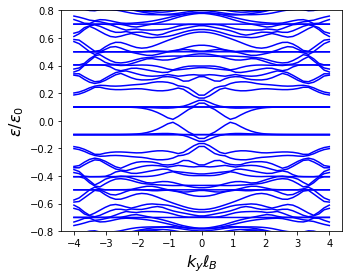

In [3]:
##### plot for notes

plt.figure(figsize=(5,4))
plt.plot(ky_sw*lB,En.T/hwc,'b')

fsize=16
plt.ylabel(r"$\varepsilon/\varepsilon_0$",fontsize = fsize)
plt.xlabel(r"$k_y \ell_B$",fontsize = fsize)
plt.ylim(-.8,.8)
# plt.xlim(-1,4)
# plt.xticks(np.arange(-4,4.1,2))
# plt.yticks(np.arange(-2,2.1,1))
# plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('figs/TS_Hoppe_Nx_%d_nu_%.2f.pdf' % (Nx,nu))
plt.show()
